# Advanced ML: Домашнее задание 3

__MCMC-сэмплирование и «пляшущие человечки».__

Студент: Чepникoв Дмитрий

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

### Чтение данных и предобработка

In [2]:
#os.chdir("d:/Code/Made/adv_ml/HW4")
         
with open('./data/AnnaKarenina.txt', 'r', encoding='utf-8') as f:
    karenina_raw = f.read()
    
with open('./data/WarAndPeace.txt', 'r', encoding='utf-8') as f:
    voina_i_mir_raw = f.read()
    
with open('./data/WarAndPeaceEng.txt', 'r', encoding='utf-8') as f:
    war_n_peace_raw = f.read()
    
with open('./data/SherlockHolmes.txt', 'r', encoding='utf-8') as f:
    sherlock_raw = f.read()
    
display('"Анна Каренина" alphabet:', 
        ' '.join(sorted(Counter(karenina_raw.lower()).keys())))

display('"Война и мир" alphabet:', 
        ' '.join(sorted(Counter(voina_i_mir_raw.lower()).keys())))

display('"War and Peace" alphabet:', 
        ' '.join(sorted(Counter(war_n_peace_raw.lower()).keys())))

display('"Sherlock Holmes" alphabet:', 
        ' '.join(sorted(Counter(sherlock_raw.lower()).keys())))

'"Анна Каренина" alphabet:'

'\n   ! ( ) * , - . / 0 1 2 3 4 5 6 7 8 9 : ; ? [ ] a b c d e f g h i j k l m n o p q r s t u v w x y z « » à á â ä ç è é ê î ó ü ý ́ а б в г д е ж з и й к л м н о п р с т у ф х ц ч ш щ ъ ы ь э ю я ё ї – ’ “ „ … №'

'"Война и мир" alphabet:'

'\t \n   ! " \' ( ) * , - . 0 1 2 3 4 5 6 7 8 9 : ; ? [ ] ` a b c d e f g h i j k l m n o p q r s t u v w x y z « » à â ä å ç è é ê í î ô ö û ü а б в г д е ж з и й к л м н о п р с т у ф х ц ч ш щ ъ ы ь э ю я ё – — “ „ …'

'"War and Peace" alphabet:'

'\n   ! " # $ % \' ( ) * , - . / 0 1 2 3 4 5 6 7 8 9 : ; = ? @ [ ] a b c d e f g h i j k l m n o p q r s t u v w x y z à ä é ê \ufeff'

'"Sherlock Holmes" alphabet:'

'\t \n   ! " # & \' ( ) * , - . 0 1 2 3 4 5 6 7 8 9 : ; ? [ ] a b c d e f g h i j k l m n o p q r s t u v w x y z \xa0 — ‘ ’ “ ” … › \ufeff'

In [3]:
ru_alphabet = "".join(sorted("йцукенгшщзхъфывапролджэячсмитьбюё "))
en_alphabet = "".join(sorted("qwertyuiopasdfghjklzxcvbnm "))

assert len(ru_alphabet) == 34
assert len(en_alphabet) == 27

display(ru_alphabet, en_alphabet)

' абвгдежзийклмнопрстуфхцчшщъыьэюяё'

' abcdefghijklmnopqrstuvwxyz'

In [4]:
def preprocess_text(text, alphabet):
    text = text.lower()
    text = "".join(c for c in text if c in alphabet)
    text = " ".join(w for w in text.split())
    return text

display(preprocess_text(voina_i_mir_raw[:100], ru_alphabet))
display(preprocess_text(war_n_peace_raw[:100], en_alphabet))

'война и мир самый известный роман льва николаевича толстого как никакое другое пр'

'the project gutenberg ebook of war and peace by leo tolstoythis ebook is for the use of anyone a'

In [5]:
karenina = preprocess_text(karenina_raw, ru_alphabet)
voina_i_mir = preprocess_text(voina_i_mir_raw, ru_alphabet)
war_n_peace = preprocess_text(war_n_peace_raw, en_alphabet)
sherlock = preprocess_text(sherlock_raw, en_alphabet)

display((f'"Анна Каренина": {len(karenina)} russian chars'))
display((f'"Война и мир" (Том 1): {len(voina_i_mir)} russian chars'))
display((f'"War and peace" (EN): {len(war_n_peace)} english chars'))
display((f'"Sherlock Holmes": {len(sherlock)} english chars'))

'"Анна Каренина": 1689751 russian chars'

'"Война и мир" (Том 1): 641183 russian chars'

'"War and peace" (EN): 3046439 english chars'

'"Sherlock Holmes": 3381372 english chars'

# 1. Базовый частотный метод по Шерлоку Холмсу

## Частоты букв по корпусам

In [6]:
karenina_unigramms = pd.Series(Counter(karenina)).sort_index()
karenina_unigramms /= karenina_unigramms.sum()

voina_i_mir_unigramms = pd.Series(Counter(voina_i_mir)).sort_index()
voina_i_mir_unigramms /= voina_i_mir_unigramms.sum()

war_n_peace_unigramms = pd.Series(Counter(war_n_peace)).sort_index()
war_n_peace_unigramms /= war_n_peace_unigramms.sum()

sherlock_unigramms = pd.Series(Counter(sherlock)).sort_index()
sherlock_unigramms /= sherlock_unigramms.sum()

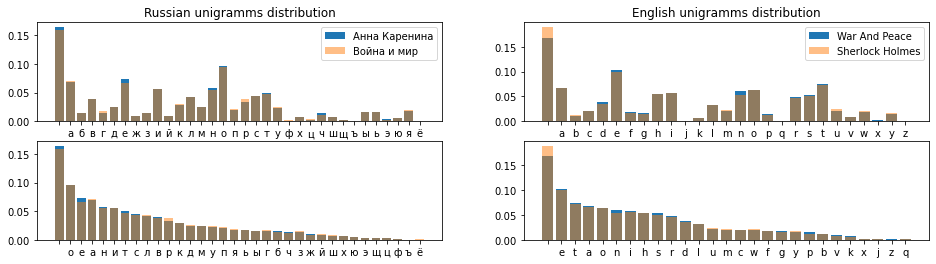

In [7]:
def plot_char_frecs(x, label=None, color=None, alpha=None):
    plt.bar(x.index, x, label=label, color=color, alpha=alpha)

plt.figure(figsize=(16,4))
plt.subplot(221)
plot_char_frecs(karenina_unigramms, label="Анна Каренина")
plot_char_frecs(voina_i_mir_unigramms, label="Война и мир", alpha=0.5)
plt.title("Russian unigramms distribution")
plt.legend()

plt.subplot(222)
plot_char_frecs(war_n_peace_unigramms, label="War And Peace")
plot_char_frecs(sherlock_unigramms, label="Sherlock Holmes", alpha=0.5)
plt.title("English unigramms distribution")
plt.legend()

plt.subplot(223)
plot_char_frecs(karenina_unigramms.sort_values(ascending=False))
plot_char_frecs(voina_i_mir_unigramms.sort_values(ascending=False), alpha=0.5)

plt.subplot(224)
plot_char_frecs(war_n_peace_unigramms.sort_values(ascending=False))
plot_char_frecs(sherlock_unigramms.sort_values(ascending=False), alpha=0.5)

plt.show()

__Распределение символов__: на разных корпусах распределение практически не отличается (для выборок большого размера)

## Зашифрование
Возьмите какие-нибудь тестовые тексты (нужно взять поменьшей мере 2-3 предложения, иначе совсем вряд ли сработает), зашифруйте их посредством случайной перестановки символов

In [8]:
class CaecarCipher:
    def __init__(self, alphabet=None, key=None, blank=' ', random_state=None):
        np.random.seed(random_state)
        self.alphabet = alphabet or " абвгдежзийклмнопрстуфхцчшщъыьэюяё"
        self.key = key or np.random.permutation(list(self.alphabet))
        self.mapping = dict(zip(self.alphabet, self.key))
        self.inverse = dict(zip(self.key, self.alphabet))
        self.blank = blank
    
    def _encrypt_char(self, c):
        return self.mapping[c] if c in self.alphabet else self.blank
    
    def _decrypt_char(self, c):
        return self.inverse[c] if c in self.alphabet else self.blank
    
    def get_mapping(self):
        return self.mapping
    
    def encrypt(self, text):
        return "".join(self._encrypt_char(c) for c in text)
    
    def decrypt(self, text):
        return "".join(self._decrypt_char(c) for c in text)

In [9]:
ru_text = karenina[1300:1700]
ru_cipher = CaecarCipher(random_state=1)
ru_ctext = ru_cipher.encrypt(ru_text)
[ru_text, ru_ctext]

['без колебаний назвал анну каренину величайшим социальным романом во всей мировой литературе писал томас маннзначение романа толстого состоит не в эстетической ценности отдельных картин а в художественной завершенности целоговойну и мир толстой называл книгой о прошлом в начале года он просил редактора журнала русский вестник мн каткова в оглавлении и даже в объявлении не называть его сочинение ром',
 'вучнхцгувтфэрнфтчътгнтффенхтьуфэфенъугэатрпэбныцёэтгкфдбньцбтфцбнъцнъыурнбэьцъцрнгэсуьтсеьунйэытгнсцбтынбтффчфтауфэуньцбтфтнсцгысцяцныцысцэснфунъниысусэауыхцрнёуффцысэнцсщугкфджнхтьсэфнтнънжещцшуысъуффцрнчтъуьпуффцысэнёугцяцъцрфенэнбэьнсцгысцрнфтчдътгнхфэяцрнцнйьцпгцбнънфтатгуняцщтнцфнйьцыэгньущтхсцьтншеьфтгтньеыыхэрнъуысфэхнбфнхтсхцътнънцягтъгуфээнэнщтшунънцвозъгуфээнфунфтчдътскнуяцныцаэфуфэуньцб']

In [10]:
en_text = war_n_peace[5300:5700]
en_cipher = CaecarCipher(alphabet=en_alphabet, random_state=1)
en_ctext = en_cipher.encrypt(en_text)
[en_text, en_ctext]

['words she greeted prince vasili kuragin a man of high rank andimportance who was the first to arrive at her reception anna pavlovnahad had a cough for some days she was as she said suffering from lagrippe grippe being then a new word in st petersburg used only by theeliteall her invitations without exception written in french and deliveredby a scarletliveried footman that morning ran as followsif ',
 'hx woqodjqu jjzjwqa bgcjqinobsbqfy nubgqnqmngqxtqdbudq ngfqngwbmax zngcjqhdxqhnoqzdjqtb ozqzxqn  bijqnzqdj q jcjazbxgqnggnqanisxigndnwqdnwqnqcxyudqtx qoxmjqwnkoqodjqhnoqnoqodjqonbwqoyttj bguqt xmqsnu baajqu baajqrjbguqzdjgqnqgjhqhx wqbgqozqajzj ory uqyojwqxgskqrkqzdjjsbzjnssqdj qbgibznzbxgoqhbzdxyzqjlcjazbxgqh bzzjgqbgqt jgcdqngwqwjsbij jwrkqnqocn sjzsbij bjwqtxxzmngqzdnzqmx gbguq ngqnoqtxssxhobtq']

## Расшифрование частотным методом

Образец шифрованного текста для опробования методов частотного расшифрования

In [11]:
SAMPLE_OFFSET = 1000
SAMPLE_LENGTH = 1000

cipher = CaecarCipher()
plain_text = karenina[SAMPLE_OFFSET : SAMPLE_OFFSET+SAMPLE_LENGTH]
enc_text = cipher.encrypt(plain_text)
enc_text

'рхюурояфхмуеймугухугюуряыцхжйтьуеугтёфйвыцхюощюокумвыхиы тхёфеунфёфйвуъхймюо яыцхгеыктяыхтхйтеыхтхгеоняуфхяфкпноепъхиуйфефхыхяойхюфоетщрхьыиулфймнфяяугухтщукюолфятднюфрдхжуимнфюитеухбмыхнпйувыцхузфявыхтщхймомфъхтхвятгхяохнйфьхдщпвоьхртюохжуйндэфяяпьхояяфхвоюфятяуъхруляухйуймонтмахзфеыцхкткетумфвыхдхкфщхвуефкоятъхяощноехояяыхвоюфятяыхнфетёоъ трхйузтоеаяпрхюурояурхнухнйфъхртюунуъхетмфюомыюфхжтйоехмуройхрояящяоёфятфхюурояохмуеймугухйуймутмхяфхнхбймфмтёфйвуъхзфяяуймтхумифеаяпьхвоюмтяхохнхьыиулфймнфяяуъхщонфю фяяуймтхзфеугунуъяыхтхртюхмуеймуъхяощпноехвятгуъхухжюу еурхнхяоёоефхгуиохуяхжюуйтехюфиовмуюохлыюяоеохюыййвтъхнфймятвхряхвомвунохнхугеонефяттхтхиолфхнхукчднефяттхяфхяощпномахфгухйуётяфятфхюурояурхиедхрфядхбмухуёфяахноляухтхжумурыхуёфяахжюу ыхнойхукхбмурхмуеймуъхругхкпхукуйяуномахйнуфхужюфифефятфхлояюохвятгохййпевуъхяохгфгфедхвумуюугухуяхнятромфеаяухжфюфётмпноехнхгуипхюокумпхяоихнуъяуъхтхртюурхгфгфеахяощпноехвятгуъхбжтёфйвтфхжюутщнфифятдхйндщояяпфхйхзфеуймяпрхртюурхужюфифефяяугухяоюуиох

### Метрика качества

Зашифровывающее преобразование действует посимвольно и сохраняет длину текста, вставки и удаления символов исключены, поэтому в качестве метрики используемя количество верно расшифрованных символов

In [12]:
def chars_accuracy(plain_text, deciphered_text):
    accuracy = 0
    for i in range(len(plain_text)):
        if plain_text[i] == deciphered_text[i]:
            accuracy +=1
    return accuracy / len(plain_text)

Расшифрование частотным методом

In [13]:
class NgramCracker:
    def __init__(self, alphabet=None, n_size=1, blank=' '):
        self.alphabet = alphabet or " абвгдежзийклмнопрстуфхцчшщъыьэюяё"
        self.n_size = n_size
        self.blank = blank
        self.freqs = None
    
    @staticmethod
    def calc_freqs(ngamms):
        freqs = pd.Series(Counter(ngamms), name='freqs').to_frame().reset_index() \
            .sort_values(by=['freqs', 'index'], ascending=False).set_index('index') \
            .loc[:,'freqs']
        return freqs
    
    @staticmethod
    def translate(ngramm, vocab, blank):
        return vocab[ngramm][0] if ngramm in vocab else blank
        
    def fit(self, text):
        n, k = len(text), self.n_size
        ngamms = (text[i:i+k] for i in range(n-k))
        self.freqs = self.calc_freqs(ngamms)
        self.freqs /= self.freqs.sum()
        return self
    
    def transform(self, text):
        n, k = len(text), self.n_size
        padded_text = text + self.blank * self.n_size
        ngamms = list(padded_text[i:i+k] for i in range(n))
        freqs = self.calc_freqs(ngamms)
        vocab = dict(zip(freqs.index, self.freqs.index))
        ngamms.extend([text[-i:] for i in range(k, 0, -1)])
        return "".join(self.translate(ngramm, vocab, self.blank) for ngramm in ngamms)

In [14]:
display(['Encrypted text', enc_text[:80]])

cracker = NgramCracker(n_size=1)
for length in [1000, 2000, 5000, 10000]:
    text = voina_i_mir[SAMPLE_OFFSET : SAMPLE_OFFSET+length]
    cracker.fit(text)
    dec_text = cracker.transform(enc_text)
    display([
        f'Original text len: {len(plain_text)}',
        plain_text[:80],
        f'Trainning text len: {length}',
        dec_text[:80],
        f'Accuracy: {chars_accuracy(plain_text, dec_text)}'
    ])

['Encrypted text',
 'рхюурояфхмуеймугухугюуряыцхжйтьуеугтёфйвыцхюощюокумвыхиы тхёфеунфёфйвуъхймюо яыц']

['Original text len: 1000',
 'м романе толстого огромную психологическую разработку души человеческой страшную',
 'Trainning text len: 1000',
 'к токиеа ворсводо одтокемц чснйороднзаспмц тиытиьовпм гмжн заролазаспоя свтижемц',
 'Accuracy: 0.291']

['Original text len: 1000',
 'м романе толстого огромную психологическую разработку души человеческой страшную',
 'Trainning text len: 2000',
 'л ролнеа воксвопо опролемц ьсиюокопигасдмц рнырнчовдм умхи гакотагасдоз сврнхемц',
 'Accuracy: 0.39']

['Original text len: 1000',
 'м романе толстого огромную психологическую разработку души человеческой страшную',
 'Trainning text len: 5000',
 'к локнеа тосвтопо оплокедц ывижосопизавмдц лнчлньотмд гдхи засоразавмоу втлнхедц',
 'Accuracy: 0.357']

['Original text len: 1000',
 'м романе толстого огромную психологическую разработку души человеческой страшную',
 'Trainning text len: 10000',
 'к рокнае тосвтояо оярокамц гвишосояичевдмц рнырньотдм змхи чесолечевдоп втрнхамц',
 'Accuracy: 0.491']

__Результат расшифрования:__ хорошо угадывается пробел, и неаиболее частые буквы 'о', 'е', 'т', 'р' и т.д.

## Частотный метод на основе биграмм

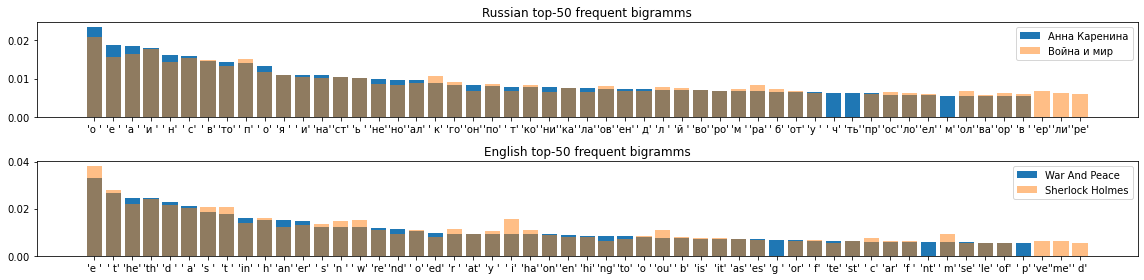

In [15]:
def calc_bigramms_hist(text, alphabet=ru_alphabet):
    padded_text = text + ' '
    ngamms = list(padded_text[i:i+2] for i in range(len(text)))
    hist = pd.Series(Counter(ngamms))
    hist /= hist.sum()
    hist.index = np.array([f"'{idx}'" for idx in hist.index])
    return hist.sort_values(ascending=False)

def plot_bigramms_hist(x, label=None, color=None, alpha=None):
    plt.bar(x.index, x, label=label, color=color, alpha=alpha)

karenina_bigrams_hist = calc_bigramms_hist(karenina)
voina_i_mir_bigrams_hist = calc_bigramms_hist(voina_i_mir)
war_n_peace_bigrams_hist = calc_bigramms_hist(war_n_peace)
sherlock_bigrams_hist = calc_bigramms_hist(sherlock)

plt.figure(figsize=(16,4))
plt.subplot(211)
plot_bigramms_hist(karenina_bigrams_hist[:50], label="Анна Каренина")
plot_bigramms_hist(voina_i_mir_bigrams_hist[:50], label="Война и мир", alpha=0.5)
plt.title("Russian top-50 frequent bigramms")
plt.legend()

plt.subplot(212)
plot_bigramms_hist(war_n_peace_bigrams_hist[:50], label="War And Peace")
plot_bigramms_hist(sherlock_bigrams_hist[:50], label="Sherlock Holmes", alpha=0.5)
plt.title("English top-50 frequent bigramms")
plt.legend()

plt.tight_layout()
plt.show()

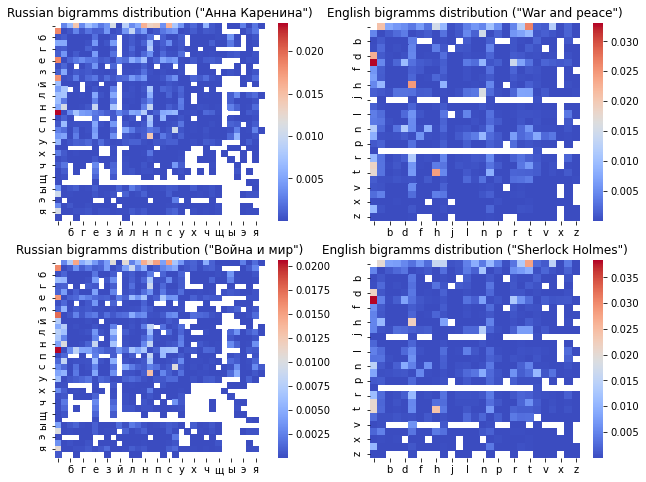

In [16]:
def calc_bigramms_heatmap(text, alphabet=ru_alphabet):
    padded_text = text + ' '
    ngamms = list(padded_text[i:i+2] for i in range(len(text)))
    freqs = pd.Series(Counter(ngamms))
    freqs /= freqs.sum()
    
    bigrams = defaultdict(defaultdict)
    for c in freqs.index:
        bigrams[c[0]][c[1]] = freqs[c]

    return pd.DataFrame(bigrams) \
        .sort_index() \
        .T.sort_index()
    
plt.figure(figsize=(16, 8))
plt.subplot(231)
sns.heatmap(calc_bigramms_heatmap(karenina), cmap='coolwarm')
plt.title('Russian bigramms distribution ("Анна Каренина")')
plt.subplot(232)
sns.heatmap(calc_bigramms_heatmap(war_n_peace), cmap='coolwarm')
plt.title('English bigramms distribution ("War and peace")')
plt.subplot(234)
sns.heatmap(calc_bigramms_heatmap(voina_i_mir), cmap='coolwarm')
plt.title('Russian bigramms distribution ("Война и мир")')
plt.subplot(235)
sns.heatmap(calc_bigramms_heatmap(sherlock), cmap='coolwarm')
plt.title('English bigramms distribution ("Sherlock Holmes")')

plt.show()

__Распределение биграмм__: распределение биграмм на различных корпусах отличается, хотя общие закономерности выражены достатовно хорошо

## Расшифрование частотным методом при помощи биграмм

In [17]:
display(['Encrypted text', enc_text[:80]])

cracker = NgramCracker(n_size=2)
for length in [1000, 2000, 5000, 10000]:
    text = voina_i_mir[SAMPLE_OFFSET : SAMPLE_OFFSET+length]
    cracker.fit(text)
    dec_text = cracker.transform(enc_text)
    display([
        f'Original text len: {len(plain_text)}',
        plain_text[:80],
        f'Trainning text len: {length}',
        dec_text[:80],
        f'Accuracy: {chars_accuracy(plain_text, dec_text)}'
    ])

['Encrypted text',
 'рхюурояфхмуеймугухугюуряыцхжйтьуеугтёфйвыцхюощюокумвыхиы тхёфеунфёфйвуъхймюо яыц']

['Original text len: 1000',
 'м романе толстого огромную психологическую разработку души человеческой страшную',
 'Trainning text len: 1000',
 'н   неь лнуркнкр ркз  паолоизуыуекздшсьтол   ы оихзтянйыаочштеес шсьтгоркн пжаол',
 'Accuracy: 0.049']

['Original text len: 1000',
 'м романе толстого огромную психологическую разработку души человеческой страшную',
 'Trainning text len: 2000',
 'ро клсто  шз  ськ сы кеы  вюифгшесыоепюо  опаапамзховд вктюе ечуеепюан л лпмшы  ',
 'Accuracy: 0.09']

['Original text len: 1000',
 'м романе толстого огромную психологическую разработку души человеческой страшную',
 'Trainning text len: 5000',
 'лвтг тоаанав нккь кштгорюиоьеабаокч пв дюиврсурвмуаднойые мпродеспв л  н ьрдурюи',
 'Accuracy: 0.052']

['Original text len: 1000',
 'м романе толстого огромную психологическую разработку души человеческой страшную',
 'Trainning text len: 10000',
 'ее ь ае юнр  нкгсяке ьвонаоршиур кбчтлдонаепаап с оон белрутн лй тлды ок зпрщона',
 'Accuracy: 0.074']

__Результат расшифрования:__ для биграмм результат получился хуже, поскольку проявляются существенные отличия в распределениях биграмм на различных корпусах небольшого размера.

## Частотный метод с применением МСМС-семплирования

Построим марковскую модель для цепочек символов текста, переходные вероятности между символами считаем как распределение биграмм.

In [18]:
class McmcCracker:
    def __init__(self, alphabet=None, n_size=2, blank=' '):
        self.alphabet = alphabet or " абвгдежзийклмнопрстуфхцчшщъыьэюяё"
        self.n_size = n_size
        self.blank = blank
        self.freqs = None
        self.chars = None
        
    @staticmethod
    def split_text(text, ngramm_size):
        n, k = len(text), ngramm_size
        return [text[i:i+k] for i in range(n-k)]

    @staticmethod
    def calc_freqs(ngamms):
        freqs = pd.Series(Counter(ngamms), name='freqs').to_frame().reset_index() \
            .sort_values(by=['freqs', 'index'], ascending=True).set_index('index') \
            .loc[:,'freqs']
        return freqs
    
    @staticmethod
    def calc_chars(freqs):
        chars = freqs \
            .groupby(by=lambda x: x[0]) \
            .sum() \
            .sort_values(ascending=False)
        return chars
    
    @staticmethod
    def shuffle(key):
        perm = list(key)
        i, j = np.random.randint(0, len(perm), size=2)
        perm[i], perm[j] = perm[j], perm[i]
        return "".join(perm)
            
    @staticmethod
    def accept(cur_llh, new_llh):
        if new_llh > cur_llh:
            return True
        return np.random.rand() < np.exp(new_llh - cur_llh)
    
    def log_likelihood(self, text):
        ngamms = self.split_text(text, self.n_size)
        freqs = self.calc_freqs(ngamms)
        nan_repl = np.amin(self.freqs.values) / 2
        
        result = 0
        for ngram, count in freqs.items():
            freq = self.freqs.get(ngram)
            if freq is None:
                freq = nan_repl
                nan_repl /= 2
            result += count * np.log(freq)
        return result
    
    def fit(self, text):
        ngamms = self.split_text(text, self.n_size)
        self.freqs = self.calc_freqs(ngamms)
        self.freqs /= self.freqs.sum()
        self.chars = self.calc_chars(self.freqs)
        self.chars /= self.chars.sum()
        return self
    
    def predict(self, text, iterations=10000, random_seed=None):
        ngamms = self.split_text(text, self.n_size)
        freqs = self.calc_freqs(ngamms)
        chars = self.calc_chars(freqs)

        for c in set(self.chars.index) - set(chars.index):
            chars[c] = self.chars[c]
            
        cur_key = "".join(chars.index)
        alphabet = "".join(sorted(self.alphabet))
        alphabet += "".join(set(cur_key) - set(alphabet))
        
        tbl = str.maketrans(cur_key, alphabet)
        cur_llh = self.log_likelihood(text.translate(tbl))
        
        best_llh = cur_llh
        self.best_key = cur_key
        
        rejected = 0
        likelihood = []
        
        np.random.seed(random_seed)
        for i in tqdm(range(iterations)):
            
            new_key = self.shuffle(cur_key)
            tbl = str.maketrans(new_key, alphabet)
            
            new_llh = self.log_likelihood(text.translate(tbl))
            likelihood.append(new_llh)
        
            if i % 1000 == 0:
                clear_output(wait=False)
                display(text.translate(tbl))
                display(f'Rejected: {rejected}/{i}')
                plt.figure(figsize=(16,4))
                plt.plot(likelihood)
                plt.title("Log likelihood")
                plt.show()

        
            if self.accept(cur_llh, new_llh):
                cur_key = new_key
                cur_llh = new_llh
                if cur_llh > best_llh:
                    best_llh = cur_llh
                    self.best_key = cur_key
            else:
                rejected += 1

        clear_output(wait=False)
        display(f'Rejected: {rejected}/{i}')
        plt.figure(figsize=(16,4))
        plt.plot(likelihood)
        plt.title("Log likelihood")
        plt.show()

        tbl = str.maketrans(self.best_key, alphabet)
        return text.translate(tbl)

In [19]:
display(['Plain text', plain_text])
display(['Encrypted text', enc_text])
display(("Original key: ", "".join(cipher.get_mapping().values())))

['Plain text',
 'м романе толстого огромную психологическую разработку души человеческой страшную глубину и силу и главное небывалый доселе у нас реализм художественного изображениявремя подтвердило эту высокую оценку из статей и книг на всех языках мира посвященных анне карениной можно составить целую библиотеку я без колебаний назвал анну каренину величайшим социальным романом во всей мировой литературе писал томас маннзначение романа толстого состоит не в эстетической ценности отдельных картин а в художественной завершенности целоговойну и мир толстой называл книгой о прошлом в начале года он просил редактора журнала русский вестник мн каткова в оглавлении и даже в объявлении не называть его сочинение романом для меня это очень важно и потому очень прошу вас об этом толстой мог бы обосновать свое определение жанра книга ссылкой на гегеля которого он внимательно перечитывал в годы работы над войной и миром гегель называл книгой эпические произведения связанные с целостным миром опред

['Encrypted text',
 'рхюурояфхмуеймугухугюуряыцхжйтьуеугтёфйвыцхюощюокумвыхиы тхёфеунфёфйвуъхймюо яыцхгеыктяыхтхйтеыхтхгеоняуфхяфкпноепъхиуйфефхыхяойхюфоетщрхьыиулфймнфяяугухтщукюолфятднюфрдхжуимнфюитеухбмыхнпйувыцхузфявыхтщхймомфъхтхвятгхяохнйфьхдщпвоьхртюохжуйндэфяяпьхояяфхвоюфятяуъхруляухйуймонтмахзфеыцхкткетумфвыхдхкфщхвуефкоятъхяощноехояяыхвоюфятяыхнфетёоъ трхйузтоеаяпрхюурояурхнухнйфъхртюунуъхетмфюомыюфхжтйоехмуройхрояящяоёфятфхюурояохмуеймугухйуймутмхяфхнхбймфмтёфйвуъхзфяяуймтхумифеаяпьхвоюмтяхохнхьыиулфймнфяяуъхщонфю фяяуймтхзфеугунуъяыхтхртюхмуеймуъхяощпноехвятгуъхухжюу еурхнхяоёоефхгуиохуяхжюуйтехюфиовмуюохлыюяоеохюыййвтъхнфймятвхряхвомвунохнхугеонефяттхтхиолфхнхукчднефяттхяфхяощпномахфгухйуётяфятфхюурояурхиедхрфядхбмухуёфяахноляухтхжумурыхуёфяахжюу ыхнойхукхбмурхмуеймуъхругхкпхукуйяуномахйнуфхужюфифефятфхлояюохвятгохййпевуъхяохгфгфедхвумуюугухуяхнятромфеаяухжфюфётмпноехнхгуипхюокумпхяоихнуъяуъхтхртюурхгфгфеахяощпноехвятгуъхбжтёфйвтфхжюутщнфифятдхйндщояяпфхйхзфеуймяпрхртюурху

('Original key: ', 'хокнгифлщтъверяужюймышьзё эчпабцдс')

'Rejected: 19266/19999'

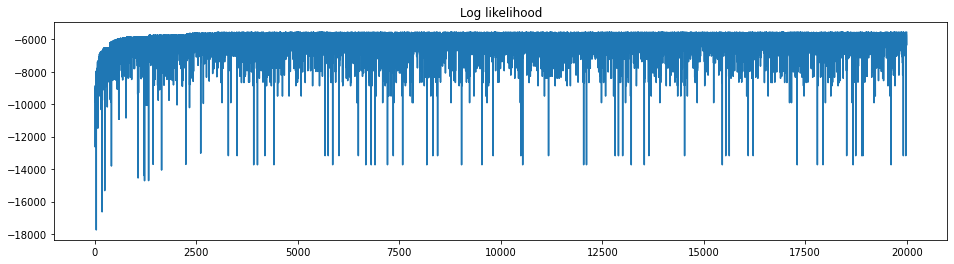

'м романе толстого огромную психологическую разработку души человеческой страшную глубину и силу и главное небывалый доселе у нас реализм художественного изображениявремя подтвердило эту высокую оценку из статей и книг на всех языках мира посвященных анне карениной можно составить целую библиотеку я без колебаний назвал анну каренину величайшим социальным романом во всей мировой литературе писал томас маннзначение романа толстого состоит не в эстетической ценности отдельных картин а в художественной завершенности целоговойну и мир толстой называл книгой о прошлом в начале года он просил редактора журнала русский вестник мн каткова в оглавлении и даже в объявлении не называть его сочинение романом для меня это очень важно и потому очень прошу вас об этом толстой мог бы обосновать свое определение жанра книга ссылкой на гегеля которого он внимательно перечитывал в годы работы над войной и миром гегель называл книгой эпические произведения связанные с целостным миром определенного народа 

'Accuracy: 1.0'

In [20]:
cracker = McmcCracker()
cracker.fit(karenina)
dec_text = cracker.predict(enc_text, iterations=20000, random_seed=2)
display(dec_text)
display(f'Accuracy: {chars_accuracy(plain_text, dec_text)}')

## Бонус1: расшифрование с помощью триграмм

__Результат:__ Модель быстрее сходится

'Rejected: 9594/9999'

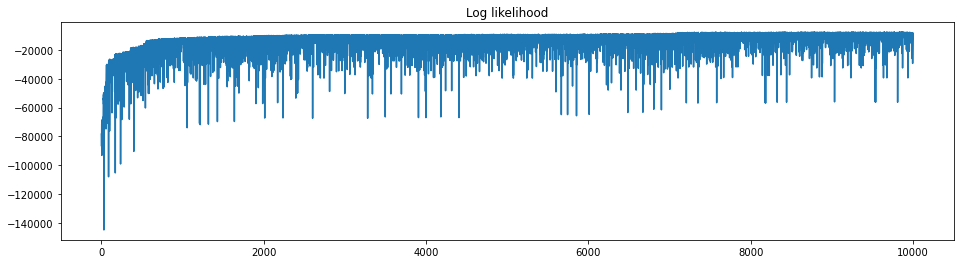

'м романе толстого огромную психологическую разработку души человеческой страшную глубину и силу и главное небывалый доселе у нас реализм художественного изображениявремя подтвердило эту высокую офенку из статей и книг на всех языках мира посвященных анне карениной можно составить фелую библиотеку я без колебаний назвал анну каренину величайшим софиальным романом во всей мировой литературе писал томас маннзначение романа толстого состоит не в эстетической фенности отдельных картин а в художественной завершенности фелоговойну и мир толстой называл книгой о прошлом в начале года он просил редактора журнала русский вестник мн каткова в оглавлении и даже в объявлении не называть его сочинение романом для меня это очень важно и потому очень прошу вас об этом толстой мог бы обосновать свое определение жанра книга ссылкой на гегеля которого он внимательно перечитывал в годы работы над войной и миром гегель называл книгой эпические произведения связанные с фелостным миром определенного народа 

'Accuracy: 0.994'

In [21]:
cracker = McmcCracker(n_size=3)
cracker.fit(karenina)
dec_text = cracker.predict(enc_text, iterations=10000, random_seed=2)
display(dec_text)
display(f'Accuracy: {chars_accuracy(plain_text, dec_text)}')

## Расшифруйте сообщение

In [22]:
task = "დჳჵჂႨშႼႨშჂხჂჲდႨსႹႭჾႣჵისႼჰႨჂჵჂႨႲႹႧჲჂႨსႹႭჾႣჵისႼჰႨჲდႩჳჲႨჇႨႠჲႹქႹႨჳႹႹჱჶდსჂႽႨႩႹჲႹႭႼჰႨჵდქႩႹႨႲႭႹႧჂჲႣჲიႨჳႩႹႭდდႨშჳდქႹႨშႼႨშჳდႨჳხდჵႣჵჂႨႲႭႣშჂჵისႹႨჂႨႲႹჵჇႧჂჲდႨჾႣႩჳჂჾႣჵისႼჰႨჱႣჵჵႨეႣႨႲႹჳჵდხსდდႨႧდჲშდႭჲႹდႨეႣხႣსჂდႨႩჇႭჳႣႨႾႹჲႽႨႩႹსდႧსႹႨႽႨსჂႧდქႹႨსდႨႹჱდჶႣნ"
task

'დჳჵჂႨშႼႨშჂხჂჲდႨსႹႭჾႣჵისႼჰႨჂჵჂႨႲႹႧჲჂႨსႹႭჾႣჵისႼჰႨჲდႩჳჲႨჇႨႠჲႹქႹႨჳႹႹჱჶდსჂႽႨႩႹჲႹႭႼჰႨჵდქႩႹႨႲႭႹႧჂჲႣჲიႨჳႩႹႭდდႨშჳდქႹႨშႼႨშჳდႨჳხდჵႣჵჂႨႲႭႣშჂჵისႹႨჂႨႲႹჵჇႧჂჲდႨჾႣႩჳჂჾႣჵისႼჰႨჱႣჵჵႨეႣႨႲႹჳჵდხსდდႨႧდჲშდႭჲႹდႨეႣხႣსჂდႨႩჇႭჳႣႨႾႹჲႽႨႩႹსდႧსႹႨႽႨსჂႧდქႹႨსდႨႹჱდჶႣნ'

'Rejected: 13503/19999'

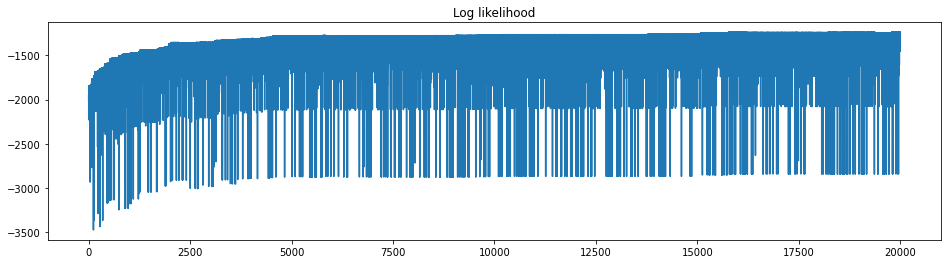

'если вы вимите нордальный или почти нордальный текст у этого соожбения который легко прочитать скорее всего вы все смелали правильно и получите даксидальный жалл за послемнее четвертое замание курса цотя конечно я ничего не ожебаნ'

In [23]:
cracker = McmcCracker(n_size=2)
cracker.fit(karenina)
cracker.predict(task, iterations=20000, random_seed=2)

## Бонус 2: применение модели MCMC-сэмплирования

Применение модели возможно в различных направлениях, где требуется анализ цепочек (последовательностей) и поиск закономерностей (patternmtaching). Кроме криптографии, это может быть анализ графов - построение маршрутов, социальные сети, биоинформатика - генетика.